# Train Eval Baseline for CelebA Dataset
---

## Import Libraries

In [1]:
import sys
sys.path.append("..")
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from disenn.datasets.celeba_dataset import CelebA

from disenn.models.conceptizers import VaeConceptizer
from disenn.models.parameterizers import ConvParameterizer
from disenn.models.aggregators import SumAggregator
from disenn.models.disenn import DiSENN

from disenn.models.losses import celeba_robustness_loss
from disenn.models.losses import bvae_loss

from disenn.utils.initialization import init_parameters

## Hardware & Seed

In [4]:
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Sample dataset for baseline

In [6]:
SAMPLE_SIZE = 1

In [7]:
celeba_dataset = CelebA(split='train', data_path='data/celeba')

In [10]:
sample_idxs = np.random.permutation(len(celeba_dataset))[:SAMPLE_SIZE]
sample_celeba_dataset = [celeba_dataset[idx] for idx in sample_idxs]
sample_images = [x for x,_ in sample_celeba_dataset]
sample_labels = [y for _,y in sample_celeba_dataset]

In [11]:
print(f"Male: {sum(sample_labels)}")

Male: 0


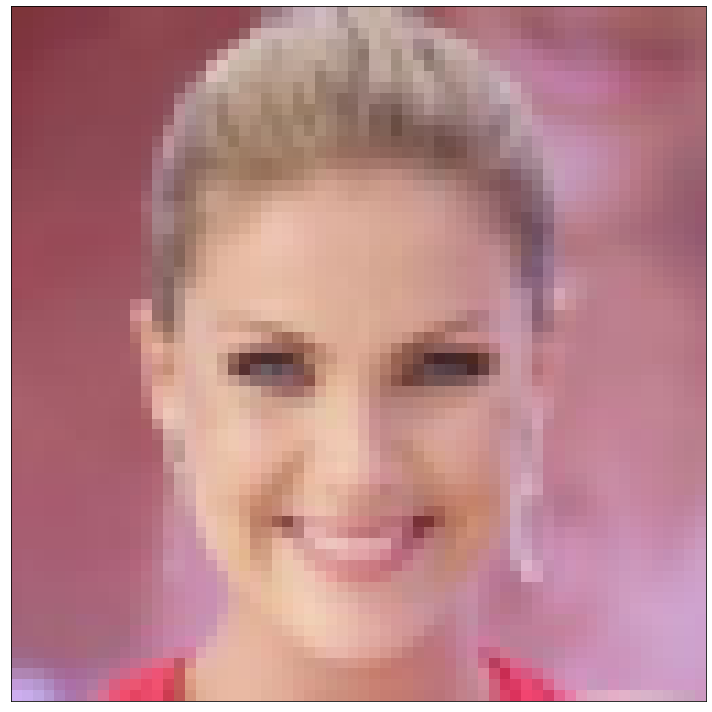

In [12]:
sample_images_grid = make_grid(sample_images)
fig, ax = plt.subplots(figsize=(20,10))
ax.imshow(sample_images_grid.numpy().transpose(1,2,0))
ax.set_xticks([])
ax.set_yticks([])
fig.tight_layout()

In [13]:
sample_dl = DataLoader(sample_celeba_dataset, batch_size=2, shuffle=True)

In [14]:
x,y = next(iter(sample_dl))

# $\beta$-VAE Conceptizer

## Forward Pass

In [15]:
conceptizer = VaeConceptizer(num_concepts=10)

In [15]:
concept_mean, concept_logvar, x_reconstruct = conceptizer(x)

In [16]:
x.shape

torch.Size([1, 3, 64, 64])

In [17]:
concept_mean.shape, concept_logvar.shape

(torch.Size([1, 10]), torch.Size([1, 10]))

In [18]:
x_reconstruct.shape

torch.Size([1, 3, 64, 64])

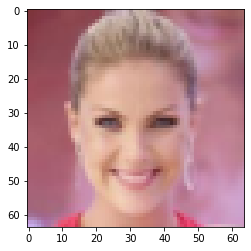

In [19]:
plt.imshow(x[0].numpy().transpose(1,2,0))

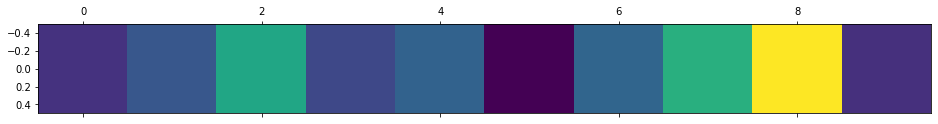

In [20]:
plt.matshow(concept_mean.detach().numpy())

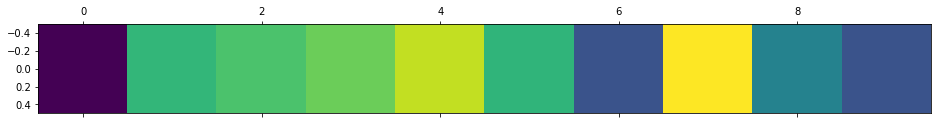

In [21]:
plt.matshow(concept_logvar.detach().numpy())

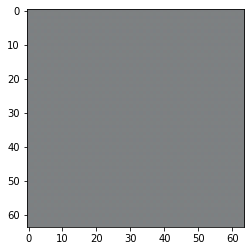

In [22]:
plt.imshow(x_reconstruct[0].detach().numpy().transpose(1,2,0))

## Sanity Check: Initial Loss

In [23]:
conceptizer = VaeConceptizer(num_concepts=10)

In [24]:
# concept_mean, concept_logvar, x_reconstruct = conceptizer(x)
# recon_loss, kl_div = BVAE_loss(x, x_reconstruct, concept_mean, concept_logvar)
# loss = recon_loss + kl_div
# loss.backward()

In [25]:
_, _, x_reconstruct = conceptizer(x)
loss = F.binary_cross_entropy(x_reconstruct, x, reduction="mean")
loss.backward()
loss

tensor(0.6882, grad_fn=<BinaryCrossEntropyBackward>)

In [26]:
x_mean = x[0].mean().item()
x_recon_mean = x_reconstruct.mean().item()

In [27]:
0.5 * np.log(0.5) + (1-0.5) * np.log(1-0.5)

-0.6931471805599453

In [28]:
x_mean * np.log(x_recon_mean) + (1-x_mean) * np.log(1 - x_recon_mean)

-0.6961596005965154

## Initialize Parameters

In [29]:
conceptizer.apply(init_parameters);

## Backward Gradients

In [30]:
print(conceptizer.decoder.tconv_block[-1].weight.grad.mean())
print(conceptizer.decoder.tconv_block[-1].weight.grad.std())

tensor(-0.0001)
tensor(0.0002)


In [31]:
print(conceptizer.decoder.tconv_block[-3].weight.grad.mean())
print(conceptizer.decoder.tconv_block[-3].weight.grad.std())

tensor(-9.9802e-07)
tensor(2.0238e-05)


In [32]:
print(conceptizer.encoder.logvar_layer.weight.grad.mean())
print(conceptizer.encoder.mu_layer.weight.grad.std())

tensor(-1.2551e-09)
tensor(9.4361e-09)


## Training

In [60]:
conceptizer = VaeConceptizer(num_concepts=10).to(device)
# conceptizer.apply(init_parameters);

In [61]:
#train_dl = DataLoader(celeba_dataset, batch_size=128, shuffle=True)

In [62]:
optimizer = optim.Adam(conceptizer.parameters())
conceptizer.train();
recorder = []

In [63]:
EPOCHS = 1000
BETA = 1
PRINT_FREQ = 10

In [64]:
for epoch in range(EPOCHS):
    for i, (x, _) in enumerate(sample_dl):
        x = x.to(device)
        optimizer.zero_grad()
        concept_mean, concept_logvar, x_reconstruct = conceptizer(x)
        recon_loss, kl_div = BVAE_loss(x, x_reconstruct, concept_mean, concept_logvar)
        loss = recon_loss + BETA * kl_div
        loss.backward()
        optimizer.step()
        recorder.append([loss.item(), recon_loss.item(), kl_div.item()])

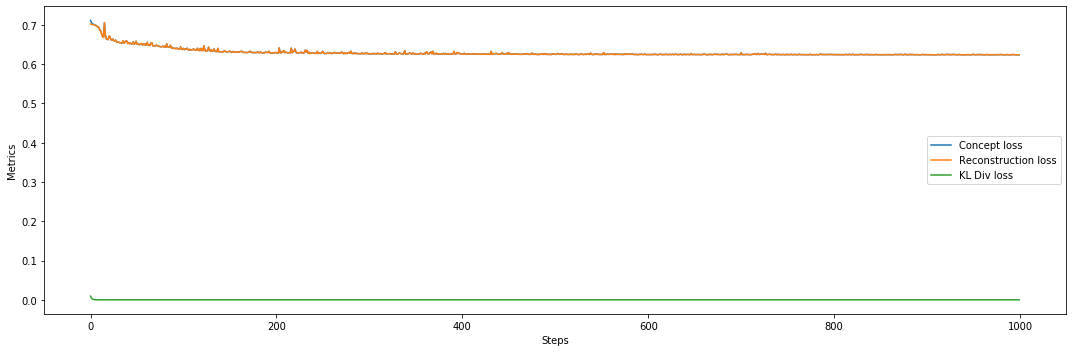

In [65]:
steps = list(range(len(recorder)))
recorder = np.array(recorder)
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(steps, recorder[:,0], label="Concept loss")
ax.plot(steps, recorder[:,1], label="Reconstruction loss")
ax.plot(steps, recorder[:,2], label="KL Div loss")
ax.set_xlabel("Steps")
ax.set_ylabel("Metrics")
ax.legend()
fig.tight_layout()

In [66]:
recorder[-1][0]

0.624011754989624

In [67]:
conceptizer.eval();

In [68]:
concept_mean, concept_logvar, x_reconstruct = conceptizer(x)
# x_reconstruct, _, _ = conceptizer(x)

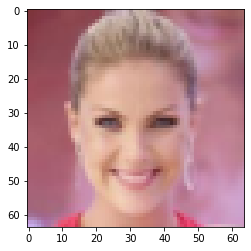

In [69]:
plt.imshow(x[0].cpu().numpy().transpose(1,2,0))

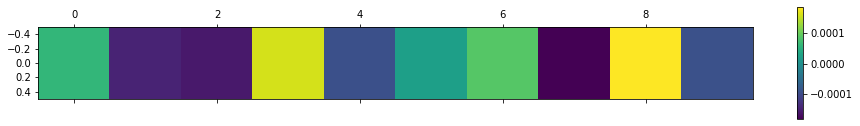

In [70]:
plt.matshow(concept_mean.detach().cpu().numpy())
plt.colorbar()

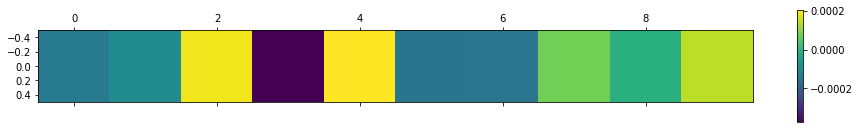

In [71]:
plt.matshow(concept_logvar.detach().cpu().numpy())
plt.colorbar()

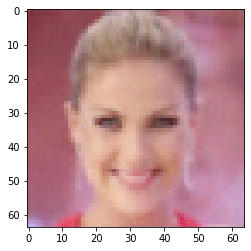

In [72]:
plt.imshow(x_reconstruct[0].detach().cpu().numpy().transpose(1,2,0))

**Observations**:  
* KL Divergence affects the reconstruction loss such that all images tend to look similar
* Reducing beta to 0 drastically improves reconstruction loss
* Increasing the number of epochs do not help
* Will increasing data size help? No.
* The initial reconstruction loss should be 0.69 which is verified
* With 100 epochs and 10 images, loss reaches 0.65 which results in hazy reconstructions
* With 1000 epochs and 1 image, loss reaches 0.62 which results in almost perfect reconstruction
* Loss of 0.62 is our goal (although 0.69 to 0.62 is a pretty close bound)
* Initialization does not help reconstruction even with 1000 epochs

# DiSENN

## Forward Pass

In [151]:
NUM_CONCEPTS = 5
NUM_CLASS = 2

In [152]:
conceptizer = VaeConceptizer(NUM_CONCEPTS)

In [153]:
parameterizer = ConvParameterizer(NUM_CONCEPTS, NUM_CLASS)

In [154]:
aggregator = SumAggregator(NUM_CLASS)

In [155]:
disenn = DiSENN(conceptizer, parameterizer, aggregator).to(device)

In [156]:
y_pred, explanation, x_construct = disenn(x)

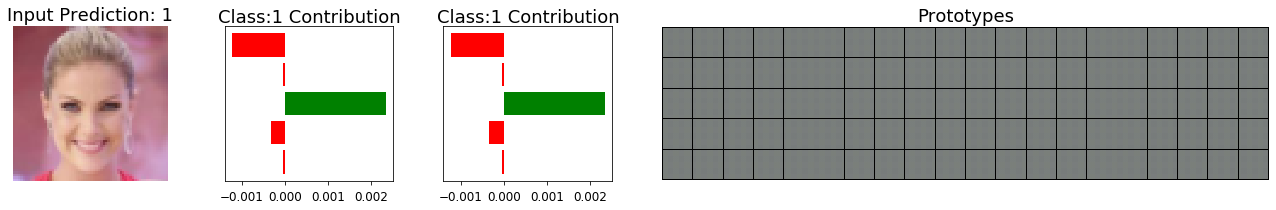

In [157]:
disenn.explain(x[0], 1, show=True, num_prototypes=20)

## Training

In [158]:
EPOCHS = 1000
BETA = 1
ROBUST_REG = 1e-4

In [159]:
opt = optim.Adam(disenn.parameters())
disenn.train();
recorder = []

In [160]:
for epoch in range(EPOCHS):
    for i, (x, labels) in enumerate(sample_dl):
        x = x.to(device)
        labels = labels.long().to(device)
        opt.zero_grad()

        x.requires_grad_(True)
        y_pred, (concepts_dist, relevances), x_reconstruct = disenn(x)

        concept_mean, concept_logvar = concepts_dist
        concepts = concept_mean

        pred_loss = F.nll_loss(y_pred.squeeze(-1), labels)
        robustness_loss = celeba_robustness_loss(x, y_pred, concepts, relevances)
        recon_loss, kl_div = BVAE_loss(x, x_reconstruct, concept_mean, concept_logvar)
        concept_loss = recon_loss + BETA * kl_div

        total_loss = pred_loss + concept_loss + (ROBUST_REG * robustness_loss) 
        total_loss.backward()
        opt.step()
        recorder.append([total_loss.item(), pred_loss.item(), robustness_loss.item(),
                         concept_loss.item(), recon_loss.item(), kl_div.item()])        

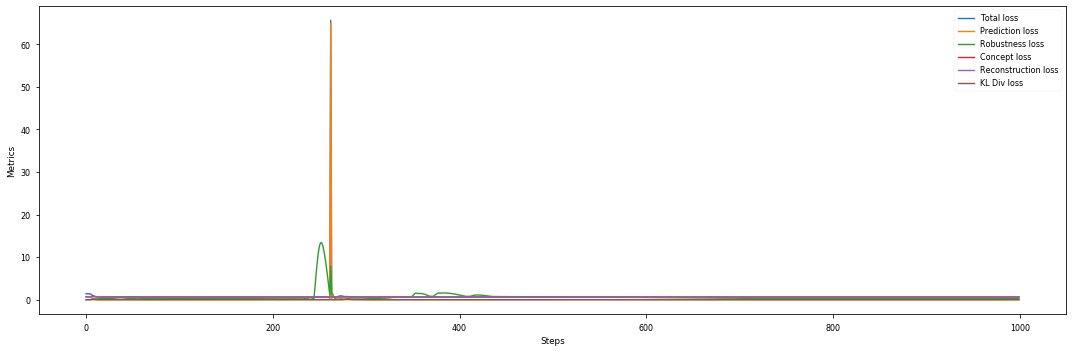

In [161]:
steps = list(range(len(recorder)))
recorder = np.array(recorder)
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(steps, recorder[:,0], label="Total loss")
ax.plot(steps, recorder[:,1], label="Prediction loss")
ax.plot(steps, recorder[:,2], label="Robustness loss")
ax.plot(steps, recorder[:,3], label="Concept loss")
ax.plot(steps, recorder[:,4], label="Reconstruction loss")
ax.plot(steps, recorder[:,5], label="KL Div loss")
ax.set_xlabel("Steps")
ax.set_ylabel("Metrics")
ax.legend()
fig.tight_layout()

In [162]:
recorder[-1]

array([6.23942673e-01, 2.50339190e-06, 3.21398765e-01, 6.23908043e-01,
       6.23905122e-01, 2.95042992e-06])

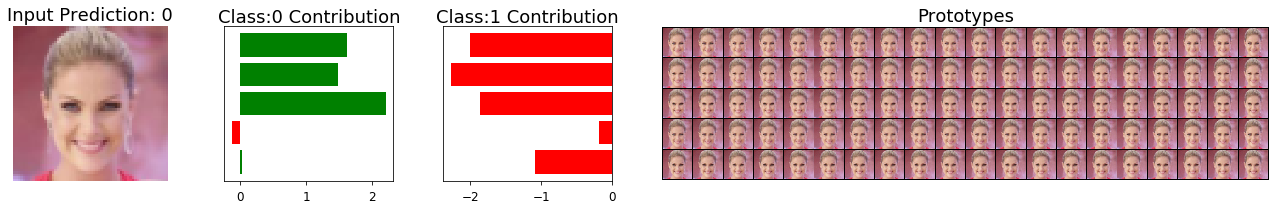

In [163]:
disenn.explain(x[0].detach(), 1, show=True, num_prototypes=20)

In [164]:
disenn.eval()
y_pred, explanations, x_reconstruct = disenn(x[0].unsqueeze(0))

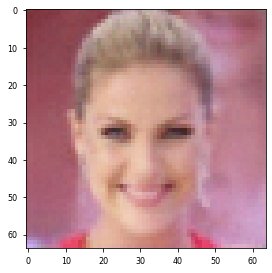

In [165]:
plt.imshow(x_reconstruct[0].detach().cpu().numpy().transpose(1,2,0))

**Observations**:  
* With 1000 epochs and 1 image, we reach the best possible loss: 0.623
* Conceptizer reconstruction is almost perfect